# imports

In [275]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
import pickle
from copy import deepcopy

# plotting
import seaborn as sns
import seaborn_image as isns
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


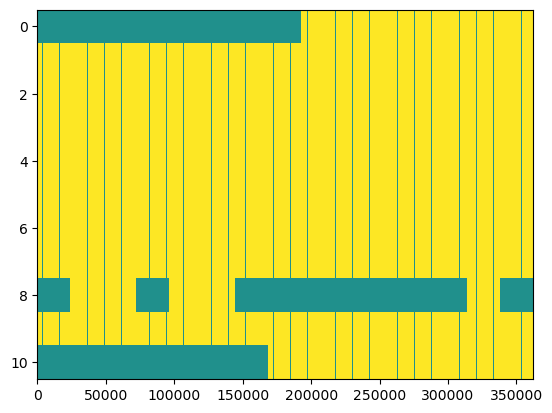

In [276]:
# load data
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

# NIM model

In [277]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [286]:
## Shared NIM
XTreg0 = 0.1
L1reg0 = 0.0001
Greg = 0.001

# subunit layer
sub0_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=8, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub0_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

sub1_par = NDNLayer.layer_dict(
    input_dims=None, num_filters=8, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub1_par['reg_vals'] = {'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC,
    norm_type=0,
    NLtype='softplus',
    bias=True,
    initialize_center = True)

nim = NDN.NDN( layer_list=[sub0_par, sub1_par, readout_par] )
#nim = NDN.NDN( layer_list=[sub0_par, readout_par] )

m.lightmode()
#m.draw_model(nim)


nim.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([360, 8])
  Layer 1:
      weight: torch.Size([8, 8])
  Layer 2:
      weight: torch.Size([8, 11])
      bias: torch.Size([11])


In [292]:
#nim.fit(data, **adam_pars, verbose=2)
#LLs1 = nim.eval_models(data[data.val_inds], null_adjusted=True)
#print(LLs1)
#print(np.mean(LLs1))
# 

#with open('nim2.pickle', 'wb') as f:
#   pickle.dump(nim, f)
with open('nim2.pickle', 'rb') as f:
    nim = pickle.load(f)

# NIM filters

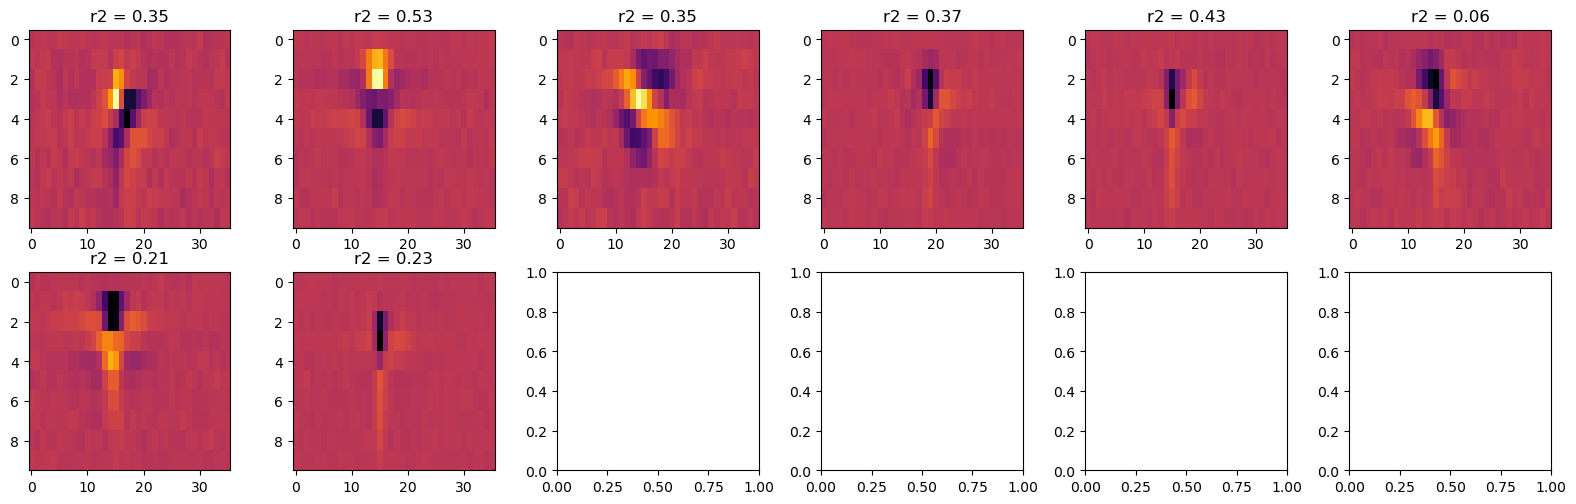

In [288]:
glm_r2s = ['%.2f'%r2 for r2 in met.r2(data, nim)]

# plot GLM filters
ss(2, 6)
for c in range(8):
    plt.subplot(2, 6, c+1)
    imagesc(nim.networks[0].layers[0].get_weights()[:,:,c], cmap='inferno')
    plt.title('r2 = ' + glm_r2s[c])
plt.show()

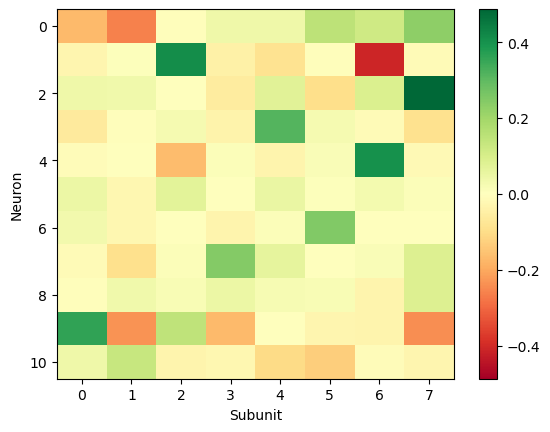

In [289]:
# Readout layer
wR = nim_all.get_weights(layer_target=1)
imagesc(wR, cmap='RdYlGn')
plt.xlabel('Subunit')
plt.ylabel('Neuron')
plt.colorbar()
plt.show()

# visualize receptive fields

In [365]:
# get the layers
layers = []
for l in range(len(nim.networks[0].layers)):
    layer = nim.networks[0].layers[l].get_weights()
    layers.append(layer)
    print(layer.shape)

(36, 10, 8)
(8, 8)
(8, 11)


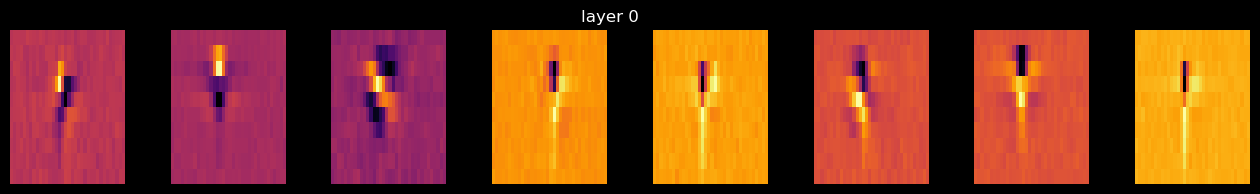

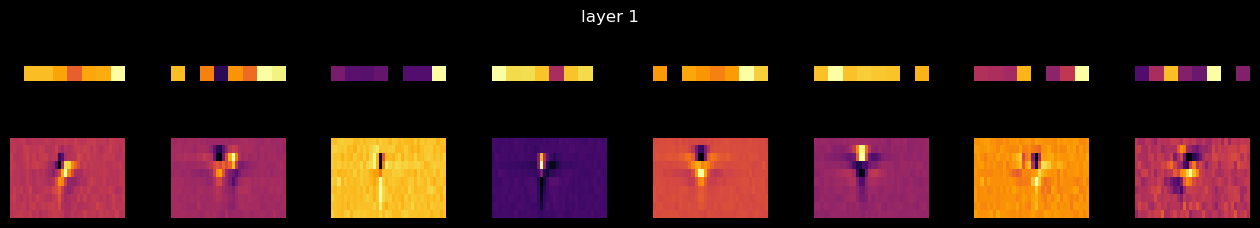

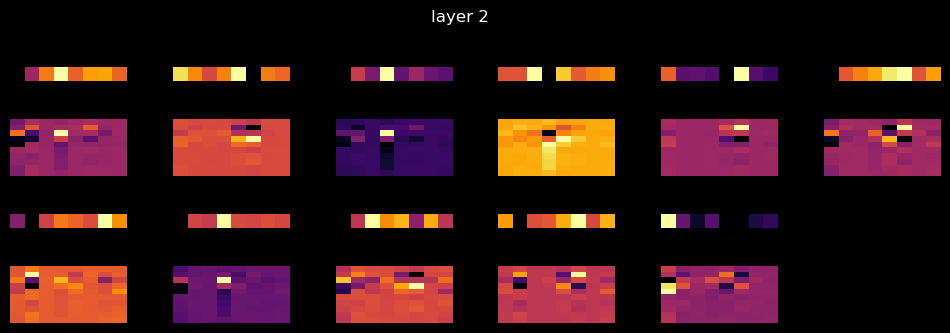

In [381]:
reload(m)
m.darkmode()
m.plot_layersNIM(layers, shapes=[(1,8), (1,8), (2,6)])

# TODO: add the top weighted elements of the previous layer displayed below the second layer (vertically)

# run the data through the network

In [331]:
y_pred = (nim({'stim': data.stim[data.val_inds]})  * data.dfs[data.val_inds]).detach().numpy()

# see the robs
nim({'stim': data.stim[data.val_inds]})

tensor([[0.0959, 2.0510, 0.0067,  ..., 0.2223, 0.5776, 0.0421],
        [0.1257, 0.1686, 0.0096,  ..., 0.1140, 0.9936, 0.0495],
        [0.1539, 0.0310, 0.0268,  ..., 0.0799, 0.1606, 0.0889],
        ...,
        [0.0737, 0.3979, 0.0129,  ..., 0.0396, 0.1188, 0.1761],
        [0.0737, 0.4981, 0.0168,  ..., 0.0460, 0.0694, 0.1632],
        [0.0609, 0.8931, 0.0224,  ..., 0.0476, 0.0629, 0.1469]],
       grad_fn=<SoftplusBackward0>)

In [392]:
# gets the position in a grid
def get_pos(shape, row, col, row_step=1):
    assert len(shape) == 2, "shape must have (num_rows, num_cols)"
    # divide row / row_step to get the actual number of rows
    # since each row has row_step # of things stacked in it
    actual_rows = row//row_step
    return actual_rows*num_cols + col

In [349]:
data.stim[0].shape, data.stim[data.val_inds].shape

(torch.Size([360]), torch.Size([68780, 360]))

In [429]:
# see layer 1
z = nim.networks[0].layers[0](data.stim[data.val_inds])
z = torch.tensor([z_i.detach().numpy() for z_i in z])
#print(z.shape)

input = data.stim[0].unsqueeze(0) # unsqueeze to make it a 2D 1xN matrix to run it through the model
prev_output = input
outputs = []
for l in range(len(nim.networks[0].layers)):
    z = nim.networks[0].layers[l](prev_output)
    # TODO: not entirely sure if I need to detach twice
    z_cpu = torch.tensor([z_i.detach().numpy() for z_i in z])
    outputs.append(z_cpu.numpy())
    print(prev_output.shape, '-->', z_cpu.shape)
    prev_output = z_cpu
    
# resize input
input = input.numpy().reshape((10, 36))

torch.Size([1, 360]) --> torch.Size([1, 8])
torch.Size([1, 8]) --> torch.Size([1, 8])
torch.Size([1, 8]) --> torch.Size([1, 11])


In [430]:
input.shape, [layer.shape for layer in layers], [output.shape for output in outputs]

((10, 36), [(36, 10, 8), (8, 8), (8, 11)], [(1, 8), (1, 8), (1, 11)])

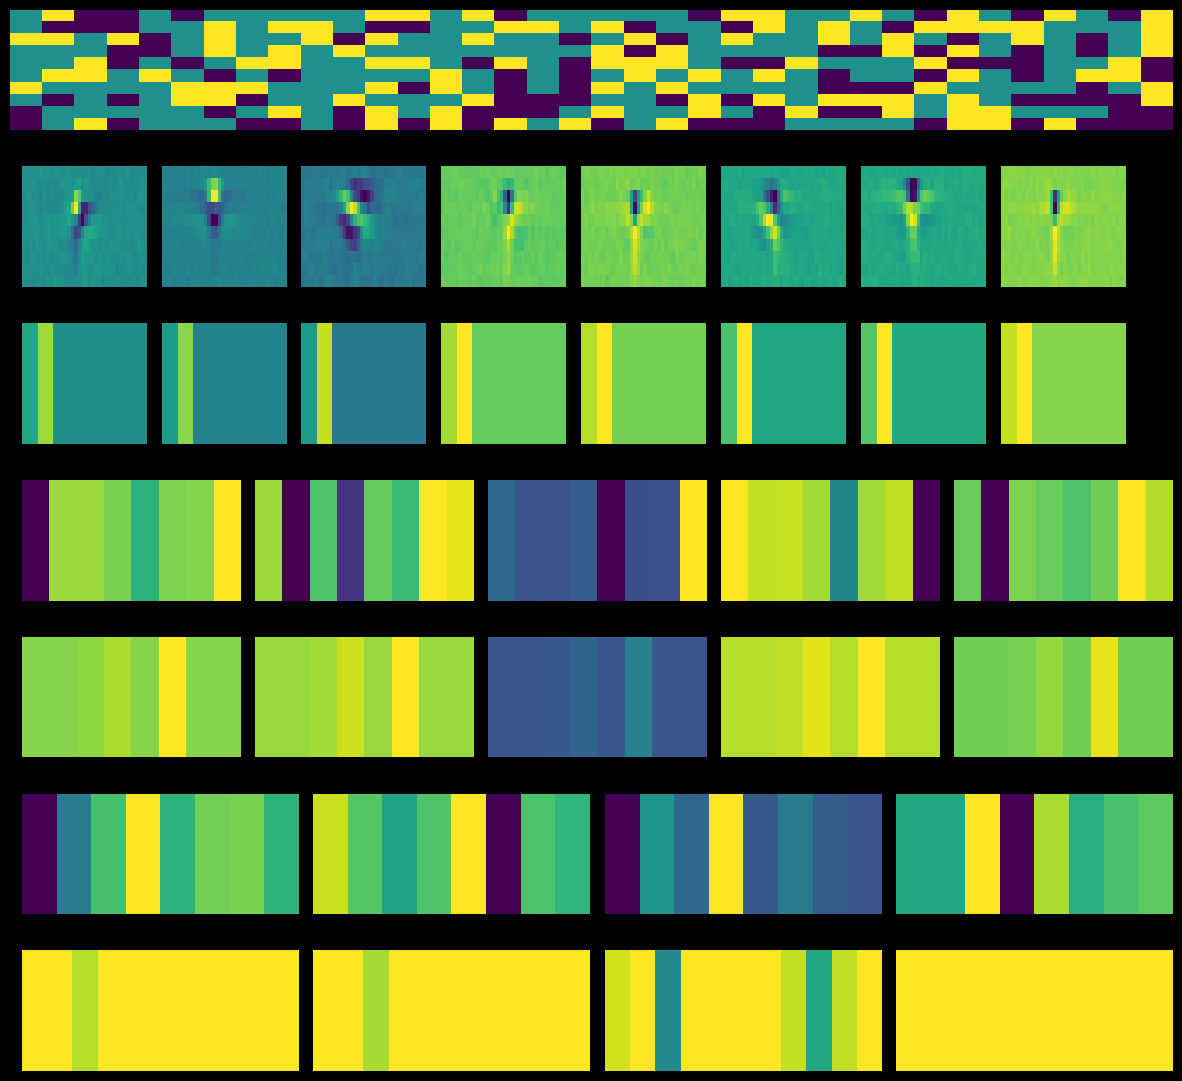

In [432]:
m.darkmode()

shapes = [(1,8), (2,5), (2,4)]

row_height = 2
width = 15
# visualize data run through a model
# 2 rows per layer except first layer
overall_num_rows = (len(layers) + len(outputs)) * 2 + 1
fig = plt.figure(figsize=(width, overall_num_rows*row_height))
# use 100 to allow finer resolution
grid = plt.GridSpec(overall_num_rows, 100, wspace=0.4, hspace=0.3)

# plot the input
box_ax = fig.add_subplot(grid[0,:100])
# to index the last axis for arrays with any number of axes
imin = np.min(input.flatten())
imax = np.max(input.flatten())
box_ax.set_axis_off() # remove axis
box_ax.imshow(input, vmin=imin, vmax=imax, aspect='auto', cmap='viridis')

# plot the layers and outputs
current_row = 1
for l in range(0, len(layers)): # go through each layer
    layer = layers[l]
    output = outputs[l]
    num_rows,num_cols = shapes[l]

    # if it is 2D, make it 3D
    if len(layer.shape) == 2:
        # insert it in the middle so it matches the format of the 3D stuff
        layer = np.expand_dims(layer, 1)
    
    # make the layer easier to iterate through and plot
    # (36, 10, 8) --> (8, 10, 36) = 8 rows of images: 36 width x 10 height
    layer = np.swapaxes(layer, 0, 2)
    
    num_boxes = layer.shape[0]
    box_idx = 0
    for i in range(0, num_rows, 2):
        # increment the global row to keep track through the layers
        for j in range(0, num_cols):
            # stop plotting if there are no more subunits in the layer
            if box_idx == num_boxes:
                break
            
            box = layer[box_idx,:,:]
            # determine proper column scaling
            # multiply the column by its desired width
            col_width = (100 // num_cols)
            j_start = (j * col_width) + 1
            j_end = (j+1)*col_width
            
            box_ax = fig.add_subplot(grid[current_row,j_start:j_end])
            # to index the last axis for arrays with any number of axes
            imin = np.min(box.flatten())
            imax = np.max(box.flatten())
            box_ax.set_axis_off() # remove axis
            box_ax.imshow(box, vmin=imin, vmax=imax, aspect='auto', cmap='viridis')
            
            output_ax = fig.add_subplot(grid[current_row+1,j_start:j_end])
            # to index the last axis for arrays with any number of axes
            imin = np.min(box.flatten())
            imax = np.max(box.flatten())
            output_ax.set_axis_off() # remove axis
            output_ax.imshow(output, vmin=imin, vmax=imax, aspect='auto', cmap='viridis')
            
            box_idx += 1 # move onto the next box
    current_row += 2

plt.show()